# ATLAS OmniFold

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Utilities

In [7]:
def standardize(data):
    orderOfMagnitude = int(math.log(np.mean(data), 10))

    return data / (10**orderOfMagnitude)

In [8]:
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)

### Load ROOT file

In [9]:
zmumu = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [10]:
zmumu.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [11]:
mybranches = []
for mykey in zmumu.keys():
    mybranches += [mykey.decode("utf-8")]

In [12]:
Events = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches,
                               col_names=mybranches,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  81.08010983467102  seconds


### Unpack data

In [13]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass = (Events.events['m_ll'] > 0) & (Events.events['m_ll'] < 200) & (
    Events.events['truth_m_ll'] > 0) & (Events.events['truth_m_ll'] < 200)

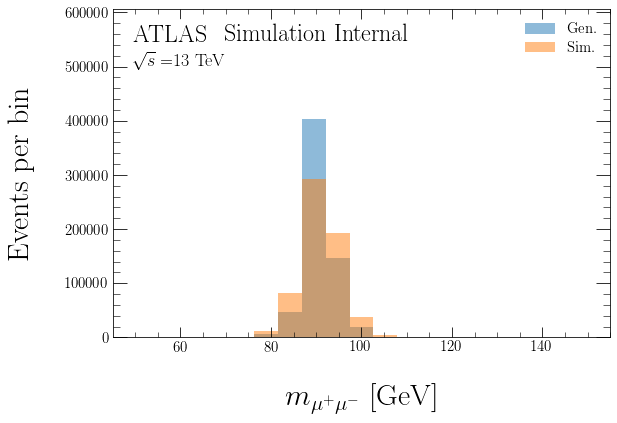

In [14]:
hG, _, _ = plt.hist(Events.events['truth_m_ll'][mypass],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5)
hS, _, _ = plt.hist(Events.events['m_ll'][mypass],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5)
plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

In [15]:
mytracks = Events.events['truth_pT_Tracks'][mypass]
ntrack_Gen = [len(mytracks[i]) for i in range(len(mytracks))]

In [16]:
mytracks = Events.events['pT_Tracks'][mypass]
ntrack_Sim = [len(mytracks[i]) for i in range(len(mytracks))]

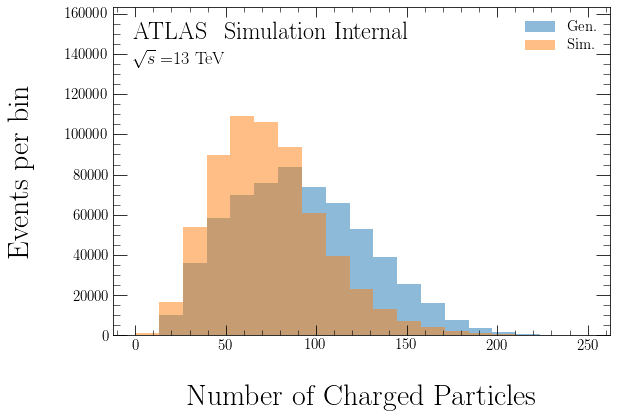

In [17]:
hG, _, _ = plt.hist(ntrack_Gen,
                    label="Gen.",
                    alpha=0.5,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_Sim,
                    label="Sim.",
                    alpha=0.5,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the nominal synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup Datasets

In [18]:
# Only one simulation, so split into nominal and "uknown" sample for now

m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S = train_test_split(
    Events.events['truth_m_ll'][mypass],
    Events.events['m_ll'][mypass],
    test_size=0.5)

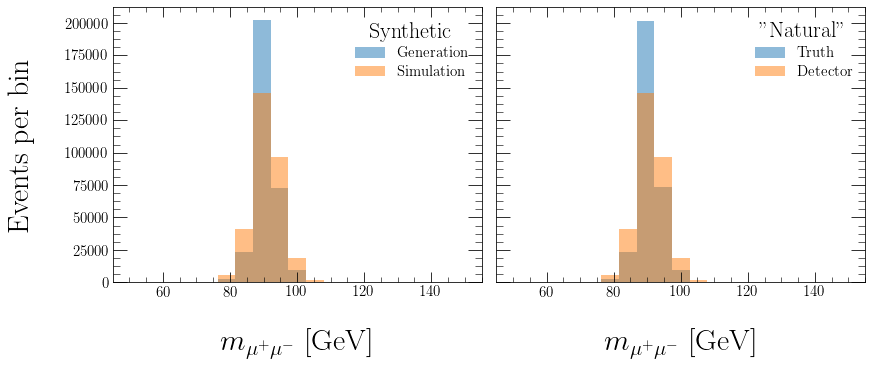

In [19]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0].hist(m_ll_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[1].hist(m_ll_unknown_S, bins=bins, alpha=0.5, label='Detector')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

In [20]:
# Only one simulation, so split into nominal and "uknown" sample for now

nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    np.array(ntrack_Gen), np.array(ntrack_Sim), test_size=0.5)

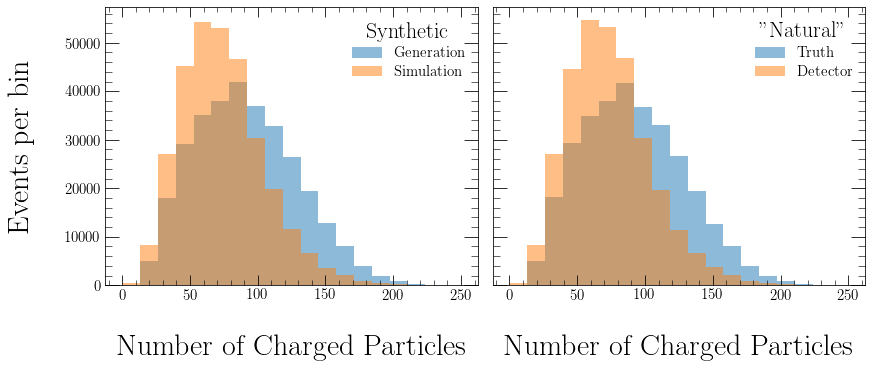

In [21]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0].hist(nTracks_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       bins=bins,
                       alpha=0.5,
                       label='Detector')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define UniFold Algorithm

In [22]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta0_G: nominal generation-level observable as Numpy array
                    
        theta0_G: nominal simulation-level observable as Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level observable 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def unifold(iterations, theta0_G, theta0_S, theta_unknown_S):
    labels0 = np.zeros(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull

    return weights, model

### Unfold $m_{\mu^+\mu^-}$

In [23]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=2,
                     theta0_G=m_ll_0_G / 100.,
                     theta0_S=m_ll_0_S / 100.,
                     theta_unknown_S=m_ll_unknown_S / 100.)





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 466582 samples, validate on 155528 samples
Epoch 1/200





466582/466582 [==============================] - 2s 4us/step - loss: 0.6934 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5004
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.4996
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.4996
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6931 - val_acc: 0.4998
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - 

466582/466582 [==============================] - 1s 2us/step - loss: 0.6930 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.4992
Epoch 20/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6930 - acc: 0.4997 - val_loss: 0.6930 - val_acc: 0.4992
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping

ITERATION: 2

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6938 - acc: 0.4995 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6937 - acc: 0.5006 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6937 - acc: 0.4992 - val_loss: 0.6937 - val_acc: 0.4992
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6937 - acc: 0.5004 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 5/200
466582/

ITERATION 1:


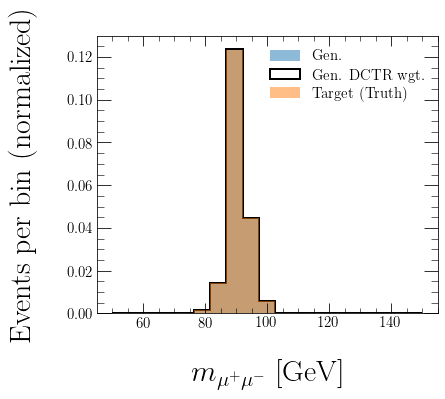

ITERATION 2:


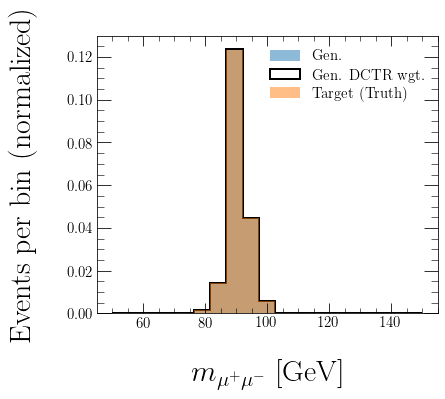

In [24]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(m_ll_0_G, bins=bins, label=r'Gen.', **plot_style_2)

    hist1 = plt.hist(m_ll_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(m_ll_unknown_G,
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold Number of Charged Particles

In [25]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=2,
                     theta0_G=nTracks_0_G / 100.,
                     theta0_S=nTracks_0_S / 100.,
                     theta_unknown_S=nTracks_unknown_S / 100.)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6933 - val_acc: 0.4982
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6916 - acc: 0.5002 - val_loss: 0.6916 - val_acc: 0.4998
Epoch 33/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6916 - acc: 0.5000 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 34/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6915 - acc: 0.5002 - val_loss: 0.6915 - val_acc: 0.5006
Epoch 35/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6916 - acc: 0.4999 - val_loss: 0.6916 - val_acc: 0.4997
Epoch 36/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6915 - acc: 0.4999 - val_loss: 0.6916 - val_acc: 0.4997
Epoch 37/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6915 - acc: 0.5001 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 38/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6916 - acc: 0.5000 - val_loss: 0.6916 - val_acc: 0.4997
Epoch 39/200
466582/466582 [=====

ITERATION 1:


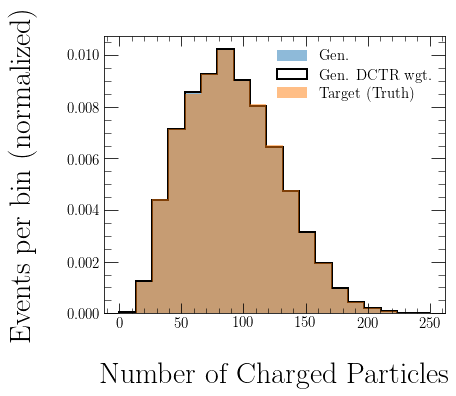

ITERATION 2:


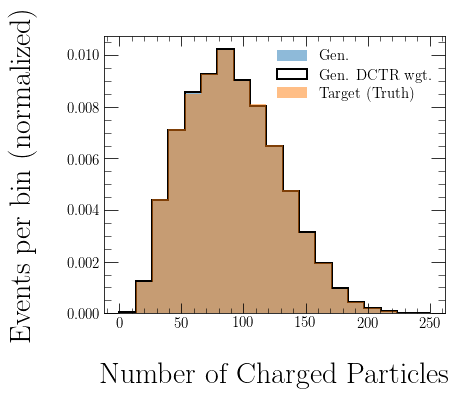

In [26]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(nTracks_0_G, bins=bins, label=r'Gen.', **plot_style_2)

    hist1 = plt.hist(nTracks_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(nTracks_unknown_G,
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the nominal synthetic dataset, and the other half as the unknown "natural" dataset.

In [27]:
K.clear_session()

### Setup datasets

In [28]:
# Only one simulation, so split into nominal and "uknown" sample for now

m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S, nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    Events.events['truth_m_ll'][mypass],
    Events.events['m_ll'][mypass],
    np.array(ntrack_Gen),
    np.array(ntrack_Sim),
    test_size=0.5)

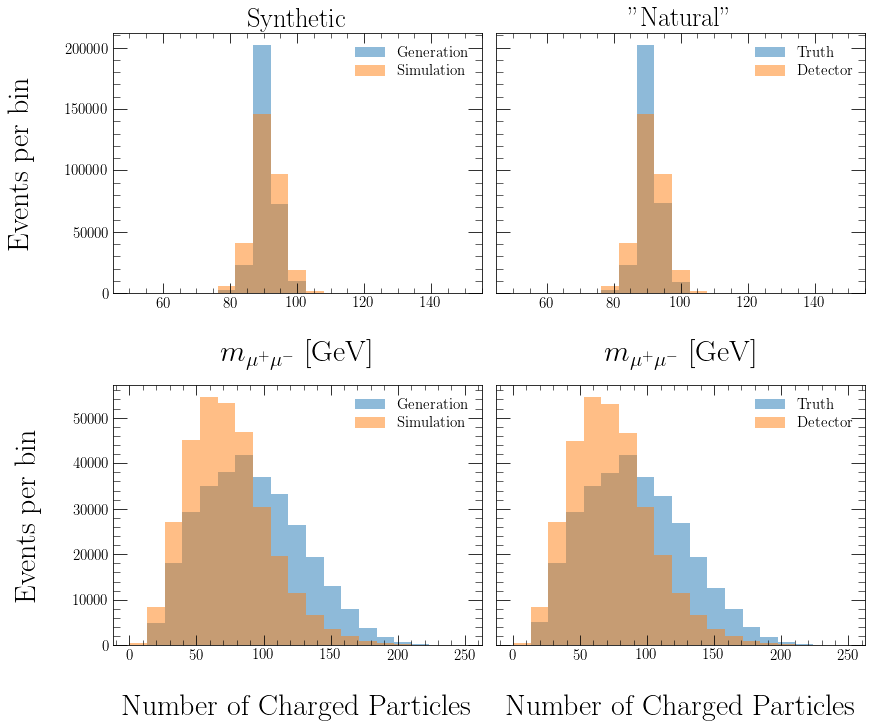

In [29]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0, 0].hist(m_ll_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define MultiFold Algorithm

In [30]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):

    theta0_G = np.stack(theta0_G, axis=1)
    theta0_S = np.stack(theta0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    labels0 = np.zeros(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull

    return weights, model

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [31]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=2,
                       theta0_G=(m_ll_0_G / 100., nTracks_0_G / 100.),
                       theta0_S=(m_ll_0_S / 100., nTracks_0_S / 100.),
                       theta_unknown_S=(m_ll_unknown_S / 100.,
                                        nTracks_unknown_S / 100.))


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_acc: 0.4992
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_acc: 0.4989
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4990
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5001
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.4988
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.4989 - val_loss: 0.6928 - val_acc: 0.4998
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.5006 - val_loss: 0.6928 - val_acc: 0.4998
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.4993 - val_loss: 0.6928 - val_acc: 0.5003
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.4996 - val_loss: 0.6928 - val_acc: 0.5002
Epoch 17/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.4998 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 18/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.5003 - val_loss: 0.6928 - val_acc: 0.5002
Epoch 19/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.4980 - val_loss: 0.6928 - val_acc: 0.5008
Epoch 20/200
466582/466582 [=====

ITERATION: 1


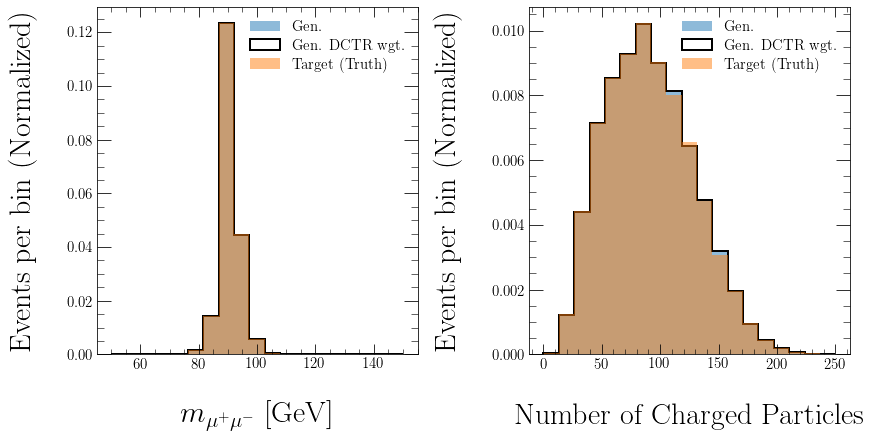

ITERATION: 2


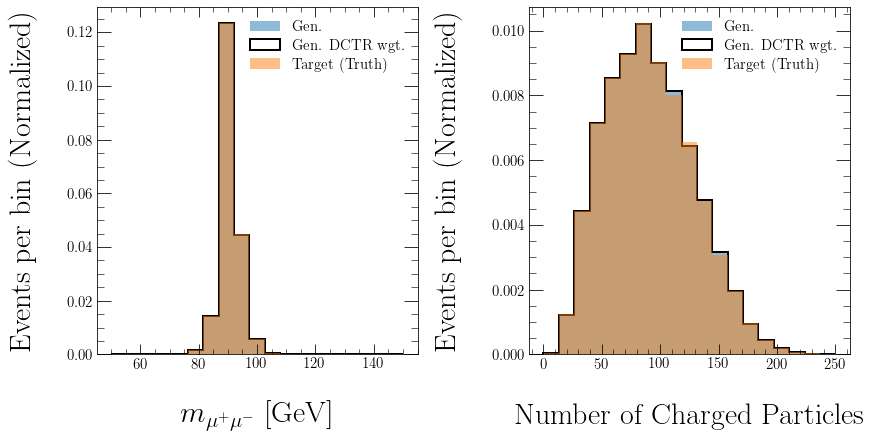

In [32]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(m_ll_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(m_ll_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(m_ll_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## OmniFold

Unfold the full phase space of the tracks.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the nominal synthetic dataset, and the other half as the unknown "natural" dataset.

In [33]:
K.clear_session()

### Setup datasets

#### Get particle charge from particle ID

Since we can only observe charge at detector-level, we must convert the PID information at particle-level to charge information.

In [34]:
# Load different particles in dataset

truth_pdgId_Tracks = Events.events['truth_pdgId_Tracks'][mypass]

In [35]:
# See what kind of particles are in event

PIDs = []

for event in truth_pdgId_Tracks:
    for ID in event:
        if ID not in PIDs:
            PIDs += [ID]

In [36]:
PIDs

[-13,
 -211,
 321,
 211,
 -321,
 13,
 -2212,
 2212,
 -3312,
 3112,
 -11,
 11,
 -3222,
 3334,
 -3112,
 3312,
 3222,
 -3334]

In [37]:
# Look up particles and their charge from
# https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf

PID_to_charge = {
    11: -1,  # e^-
    13: -1,  # mu^-
    211: 1,  # pi^+
    321: 1,  # K^+
    2212: 1,  # p
    3112: -1,  # Sigma^-
    3312: -1,  # Xi^-
    3222: +1,  # Sigma^+
    3334: -1
}  # Omega^-

In [38]:
def get_charge(pdgID):
    charges = awkward.array.jagged.JaggedArray.copy(pdgID)
    for i in range(len(charges)):
        for j in range(len(charges[i])):
            PID = charges[i][j]
            # anti-particles have a negative sign
            sign = PID / abs(PID)
            try:
                charge = sign * PID_to_charge[abs(PID)]
            except KeyError:
                print(
                    "Unknown PID encountered: {}. Please add PID and corresponding charge to 'PID_to_charge.'"
                    .format(PID))
                break
            charges[i][j] = charge
    return charges

#### Load and process tracks

Unfolding the full phase space involves the use of EnergyFlow PFNs, which take zero-padded arrays as input.

In [39]:
truth_pT_Tracks = Events.events['truth_pT_Tracks'][mypass]
pT_Tracks = Events.events['pT_Tracks'][mypass]

truth_eta_Tracks = Events.events['truth_eta_Tracks'][mypass]
eta_Tracks = Events.events['eta_Tracks'][mypass]

truth_phi_Tracks = Events.events['truth_phi_Tracks'][mypass]
phi_Tracks = Events.events['phi_Tracks'][mypass]

truth_charge_Tracks = get_charge(truth_pdgId_Tracks)
charge_Tracks = Events.events['charge_Tracks'][mypass]

In [40]:
sum_pT_Tracks_G = [
    np.sum(truth_pT_Tracks[i]) for i in range(len(truth_pT_Tracks))
]
sum_pT_Tracks_S = [np.sum(pT_Tracks[i]) for i in range(len(pT_Tracks))]

In [41]:
def get_max_dim(array):
    max_dim = max([len(array[i]) for i in range(len(array))])

    return max_dim

In [42]:
# normalize or standardize pT and center (y, phi)
def normalize_event(x, normalize=True):
    if normalize:
        yphi_avg = np.average(x[:, 1:3], weights=x[:, 0], axis=0)
        x[:, 1:3] -= yphi_avg
        x[:, 0] /= x[:, 0].sum()
    else:  # standardize
        x[:, 0] /= 100.
    return x

In [43]:
def preprocess_data(pT, eta, phi, charge, max_num_particles=None):
    num_events = len(pT)
    if max_num_particles == None:
        max_num_particles = get_max_dim(pT)

    result = np.empty(shape=(num_events, max_num_particles, 4))

    for i in range(num_events):
        pad_length = max_num_particles - len(pT[i])
        pad = np.zeros(shape=(pad_length, 4))

        event = np.stack((pT[i], eta[i], phi[i], charge[i]), axis=1)
        event = normalize_event(event, normalize=True)

        result[i] = np.concatenate((event, pad))

    return result

In [44]:
Tracks_G = preprocess_data(truth_pT_Tracks, truth_eta_Tracks, truth_phi_Tracks,
                           truth_charge_Tracks)
Tracks_S = preprocess_data(pT_Tracks, eta_Tracks, phi_Tracks, charge_Tracks)

In [45]:
np.save('Tracks_S1.npy', Tracks_S)

In [46]:
# Only one simulation, so split into nominal and "uknown" sample for now

shuffle = train_test_split(Tracks_G,
                           Tracks_S,
                           sum_pT_Tracks_G,
                           sum_pT_Tracks_S,
                           test_size=0.5)

Tracks_0_G = shuffle[0]
Tracks_unknown_G = shuffle[1]
Tracks_0_S = shuffle[2]
Tracks_unknown_S = shuffle[3]
sum_pT_Tracks_0_G = shuffle[4]
sum_pT_Tracks_unknown_G = shuffle[5]
sum_pT_Tracks_0_S = shuffle[6]
sum_pT_Tracks_unknown_S = shuffle[7]

#### Construct observables

To verify fidelity of unfolding.

In [47]:
def get_nTracks(Tracks):
    result = []

    for i in range(len(Tracks)):
        mask = Tracks[i, :, 0] > 0
        nTracks = np.sum(mask)
        result += [nTracks]

    return np.array(result)

In [48]:
nTracks_0_G = get_nTracks(Tracks_0_G)
nTracks_unknown_G = get_nTracks(Tracks_unknown_G)
nTracks_0_S = get_nTracks(Tracks_0_S)
nTracks_unknown_S = get_nTracks(Tracks_unknown_S)

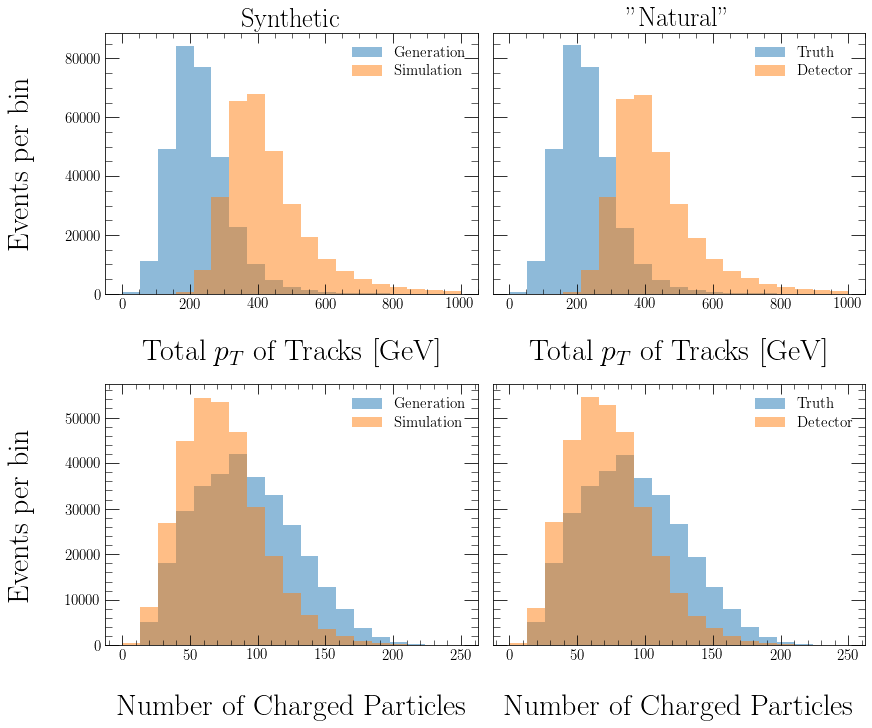

In [49]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(0, 1000, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('Total $p_T$ of Tracks [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('Total $p_T$ of Tracks [GeV]')
hG1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define OmniFold Algorithm

In [50]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta0_G: nominal generation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta0_G: nominal simulation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level  events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        Returns:
        - A Numpy array of weights to reweight observable distributions 
        from theta0_G to the unfolded observable distribution from
        theta_unknown_S
        
        - The model used to calculate those weights
"""


def omnifold(iterations, theta0_G, theta0_S, theta_unknown_S):
    labels0 = np.zeros(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=10, restore_best_weights=True)



    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=1000)
        weights = f / (1. - f)
        return np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        print("Jumpstarting Model\n")
        count = 0
        while count < 20:
            count += 1

            model.model.compile(loss='binary_crossentropy',
                                optimizer=keras.optimizers.Adam(),
                                metrics=['accuracy'])
            history = model.fit(X_train_1,
                                Y_train_1,
                                sample_weight=w_train_1,
                                epochs=1,
                                batch_size=10000,
                                validation_data=(X_test_1, Y_test_1, w_test_1),
                                verbose=1)
            if (history.history['val_loss'][0] < history.history['loss'][0]) or history.history['val_loss'][0]<1:
                break
            else:
                reset_weights(model.model)
                
        print("Training Model\n")
        model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.model.compile(loss='binary_crossentropy',
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull

    return weights, model

### Unfold the Full Phase Space

In [51]:
weights, _ = omnifold(iterations=2,
                      theta0_G=Tracks_0_G,
                      theta0_S=Tracks_0_S,
                      theta_unknown_S=Tracks_unknown_S)


ITERATION: 1

STEP 1

Jumpstarting Model

Train on 466582 samples, validate on 155528 samples
Epoch 1/1
466582/466582 [==============================] - 224s 479us/step - loss: 2.9367 - acc: 0.5001 - val_loss: 0.8423 - val_acc: 0.5008
Training Model

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 273s 585us/step - loss: 0.7495 - acc: 0.5011 - val_loss: 0.6996 - val_acc: 0.5011
Epoch 2/200
466582/466582 [==============================] - 276s 592us/step - loss: 0.7097 - acc: 0.5009 - val_loss: 0.6959 - val_acc: 0.4989
Epoch 3/200
466582/466582 [==============================] - 277s 594us/step - loss: 0.7001 - acc: 0.5002 - val_loss: 0.6947 - val_acc: 0.4986
Epoch 4/200
466582/466582 [==============================] - 276s 592us/step - loss: 0.6977 - acc: 0.5004 - val_loss: 0.6956 - val_acc: 0.5003
Epoch 5/200
466582/466582 [==============================] - 277s 595us/step - loss: 0.6968 - acc: 0.5003 - val_loss: 0.6963

466582/466582 [==============================] - 263s 565us/step - loss: 0.6938 - acc: 0.4997 - val_loss: 0.6938 - val_acc: 0.4998
Epoch 3/200
466582/466582 [==============================] - 252s 540us/step - loss: 0.6938 - acc: 0.5006 - val_loss: 0.6938 - val_acc: 0.4998
Epoch 4/200
466582/466582 [==============================] - 268s 574us/step - loss: 0.6938 - acc: 0.4993 - val_loss: 0.6938 - val_acc: 0.4998
Epoch 5/200
466582/466582 [==============================] - 268s 575us/step - loss: 0.6938 - acc: 0.4999 - val_loss: 0.6938 - val_acc: 0.4998
Epoch 6/200
466582/466582 [==============================] - 267s 573us/step - loss: 0.6938 - acc: 0.4996 - val_loss: 0.6938 - val_acc: 0.4998
Epoch 7/200
466582/466582 [==============================] - 267s 572us/step - loss: 0.6938 - acc: 0.4998 - val_loss: 0.6938 - val_acc: 0.4998
Epoch 8/200
466582/466582 [==============================] - 264s 566us/step - loss: 0.6938 - acc: 0.4996 - val_loss: 0.6938 - val_acc: 0.5002
Epoch 9/200

ITERATION: 1


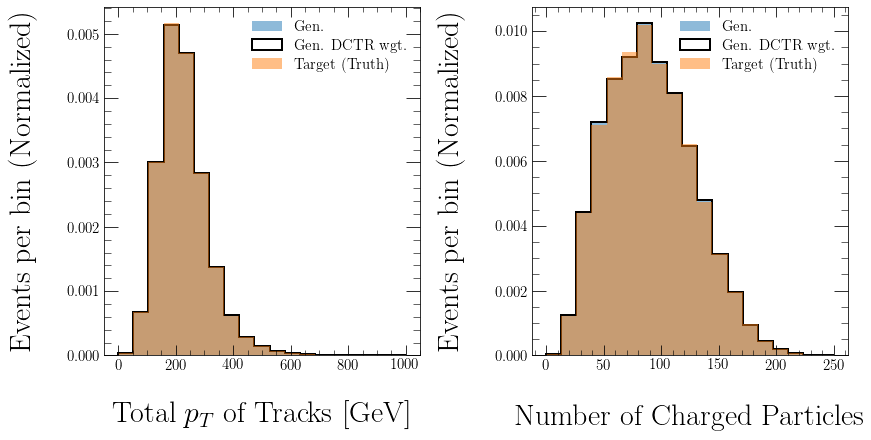

ITERATION: 2


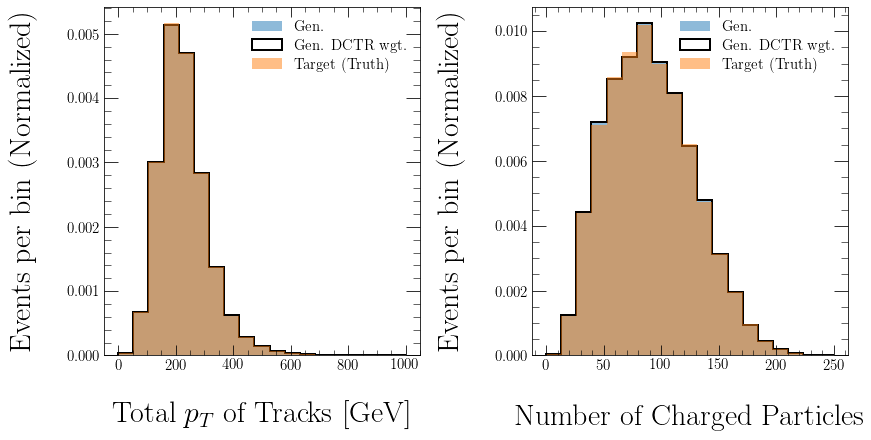

In [52]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0, 1000, 20)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax[0].set_xlabel('Total $p_T$ of Tracks [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(sum_pT_Tracks_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(sum_pT_Tracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(sum_pT_Tracks_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()